In [1]:
import numpy as np
from pathlib import Path
import shutil
import os
from utils import visualizer
from sklearn.model_selection import GroupKFold
from stages.evaluate import evaluate
from keras.utils import to_categorical

from keras.optimizers import Adam
from models.cnn_lstm import CnnLstm
from stages.load_data import DreemHeadbandLoader
from stages.preprocess import GenericPreprocesser
from stages.augment_data import FilterUncorrelated, OverlappingWindows, Sequence
from stages.feature_extraction import PassThrough
from stages.create_generator import create_gens

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)



In [2]:
import numpy as np
from pathlib import Path
import shutil
import os
from utils import visualizer
from sklearn.model_selection import GroupKFold
from stages.evaluate import evaluate
from keras.utils import to_categorical

# iteration components
from keras.optimizers import Adam
from models.cnn_lstm import CnnLstm
from stages.load_data import DreemHeadbandLoader
from stages.preprocess import GenericPreprocesser
from stages.augment_data import FilterUncorrelated, OverlappingWindows, Sequence
from stages.feature_extraction import PassThrough
from stages.create_generator import create_gens

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

iteration = {
    'iteration_name': 'cnn_lstm_dreem',
    'load_model_from_file': False,
    'notes': 'initial cnn lstm with dreem',
    'dataset_loader': DreemHeadbandLoader(
        dataset_dir='../data/dreem',
        use_visualization_signal=False,
        records=range(1, 13),
        expert_scorer_to_use=1,
        channels=[1, 2],
    ),
    'preprocesser': GenericPreprocesser(
        epoch_length=30,
        original_sample_rate=250,
        downsample_factor=5,
        highpass_f=0.50,
        flush_cache=True,
        visualize=False
    ),
    'data_augmenter': Sequence([]),
    'feature_extractor': PassThrough(),
    'model': CnnLstm(
        input_shape=(50*30,2), # set this to ( downsample freq * epoch length, #channels)
        filters=[8, 16, 32],
        kernel_size = [8, 8, 8],
        lstm_reshape=(32,1), # may need to change depending on sample ratet
        lstm_units=[64, 64]
    ),
    'compile': {
        'optimizer': Adam(lr=0.001),
        'loss': 'categorical_crossentropy',
        'metrics': ['accuracy']
    },
    'fit': {
        'shuffle': True,
        'epochs': 100,
        'workers': 6,
        'batch_size': 32
    },
}

iteration_dir = os.path.join('.','iterations', iteration['iteration_name'])
if not iteration['load_model_from_file']:
    if Path(iteration_dir).exists():
        shutil.rmtree(Path(iteration_dir))

    Path(iteration_dir).mkdir()

    with open(iteration_dir + "/iteration.txt", "w") as file:
        iteration_str = "\n".join("{}\t{}".format(k, v) for k, v in iteration.items())
        file.write(iteration_str)


In [3]:
print('Loading Dataset')
P_X, P_y = iteration['dataset_loader'].read_dataset()

print('Preprocessing data.')
P_X, P_y = iteration['preprocesser'].preprocess(P_X, P_y)

print('Augmenting data.')
P_X, P_y = iteration['data_augmenter'].augment(P_X, P_y)

print('Featurizing input data.')
P_X, P_y = iteration['feature_extractor'].extract(P_X, P_y)



Loading Dataset
Preprocessing data.
Using data preprocesser: GenericPreprocesser
Generating preprocessed dataset.
Preprocessing Channel 1
Downsampling signal.
Filtering signal.
Partitioning signal into epochs.
Preprocessing Channel 2
Downsampling signal.
Filtering signal.
Partitioning signal into epochs.
Preprocessing Channel 1
Downsampling signal.
Filtering signal.
Partitioning signal into epochs.
Preprocessing Channel 2
Downsampling signal.
Filtering signal.
Partitioning signal into epochs.
Augmenting data.
Featurizing input data.


Compiling model.
*****************************
Leaving out patient 1
*****************************
Create data generator.
Fitting model.
Epoch 1/100
30/30 [==============================] - 1s 38ms/step - loss: 1.7200 - accuracy: 0.1896 - val_loss: 2.2408 - val_accuracy: 0.0754
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 1.5824 - accuracy: 0.3406 - val_loss: 2.1562 - val_accuracy: 0.0970
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 1.4973 - accuracy: 0.4083 - val_loss: 2.1616 - val_accuracy: 0.0841
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 1.4625 - accuracy: 0.3771 - val_loss: 2.2769 - val_accuracy: 0.1196
Epoch 5/100
30/30 [==============================] - 1s 17ms/step - loss: 1.4271 - accuracy: 0.4062 - val_loss: 2.5659 - val_accuracy: 0.0970
Epoch 6/100
30/30 [==============================] - 1s 17ms/step - loss: 1.3919 - accuracy: 0.4656 - val_loss: 2.7902 - val_accuracy: 0.0894
Epoch 7/100

30/30 [==============================] - 1s 17ms/step - loss: 0.8572 - accuracy: 0.6500 - val_loss: 4.2698 - val_accuracy: 0.1207
Epoch 58/100
30/30 [==============================] - 1s 17ms/step - loss: 0.8974 - accuracy: 0.6323 - val_loss: 4.1947 - val_accuracy: 0.1390
Epoch 59/100
30/30 [==============================] - 1s 17ms/step - loss: 0.8894 - accuracy: 0.6271 - val_loss: 4.2397 - val_accuracy: 0.1433
Epoch 60/100
30/30 [==============================] - 0s 17ms/step - loss: 0.8264 - accuracy: 0.6344 - val_loss: 4.5353 - val_accuracy: 0.1347
Epoch 61/100
30/30 [==============================] - 0s 16ms/step - loss: 0.8034 - accuracy: 0.6583 - val_loss: 5.0138 - val_accuracy: 0.1412
Epoch 62/100
30/30 [==============================] - 1s 17ms/step - loss: 0.7865 - accuracy: 0.6687 - val_loss: 4.1075 - val_accuracy: 0.1509
Epoch 63/100
30/30 [==============================] - 1s 17ms/step - loss: 0.7466 - accuracy: 0.6792 - val_loss: 5.0614 - val_accuracy: 0.1476
Epoch 64/100

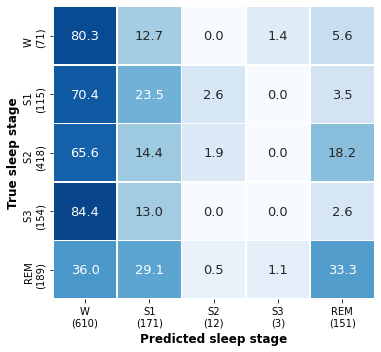

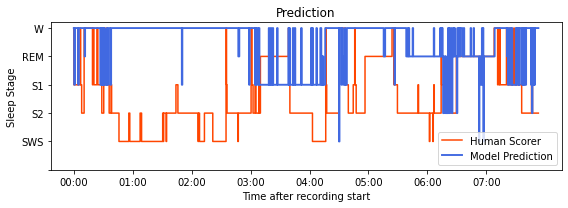

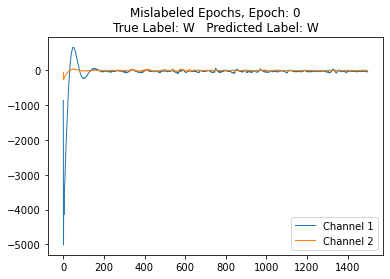

Resetting model.
*****************************
Leaving out patient 2
*****************************
Create data generator.
Fitting model.
Epoch 1/100
29/29 [==============================] - 1s 18ms/step - loss: 1.6090 - accuracy: 0.1401 - val_loss: 1.6998 - val_accuracy: 0.1646
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 1.5448 - accuracy: 0.1994 - val_loss: 1.6464 - val_accuracy: 0.1771
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 1.4753 - accuracy: 0.2640 - val_loss: 1.6564 - val_accuracy: 0.2094
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 1.3536 - accuracy: 0.3642 - val_loss: 1.6451 - val_accuracy: 0.2031
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 1.2695 - accuracy: 0.3944 - val_loss: 1.6445 - val_accuracy: 0.3792
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 1.2745 - accuracy: 0.4159 - val_loss: 1.7776 - val_accuracy: 0.2042
Epoch 7/100

29/29 [==============================] - 1s 18ms/step - loss: 0.5430 - accuracy: 0.7823 - val_loss: 2.1795 - val_accuracy: 0.3531
Epoch 58/100
29/29 [==============================] - 1s 18ms/step - loss: 0.5741 - accuracy: 0.7662 - val_loss: 2.2331 - val_accuracy: 0.2490
Epoch 59/100
29/29 [==============================] - 0s 17ms/step - loss: 0.6349 - accuracy: 0.7317 - val_loss: 2.1313 - val_accuracy: 0.3927
Epoch 60/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5322 - accuracy: 0.8006 - val_loss: 2.1585 - val_accuracy: 0.4000
Epoch 61/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5297 - accuracy: 0.7769 - val_loss: 2.1876 - val_accuracy: 0.4031
Epoch 62/100
29/29 [==============================] - 0s 17ms/step - loss: 0.4967 - accuracy: 0.7920 - val_loss: 2.1357 - val_accuracy: 0.4073
Epoch 63/100
29/29 [==============================] - 0s 17ms/step - loss: 0.4773 - accuracy: 0.8168 - val_loss: 2.1616 - val_accuracy: 0.3958
Epoch 64/100

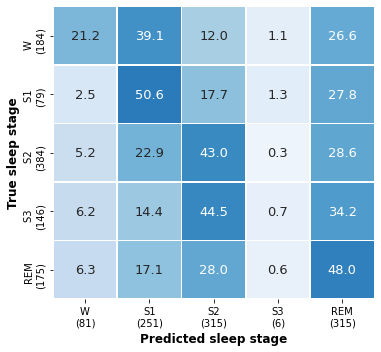

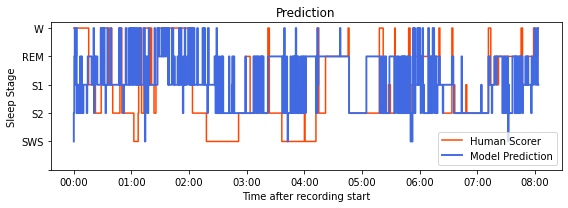

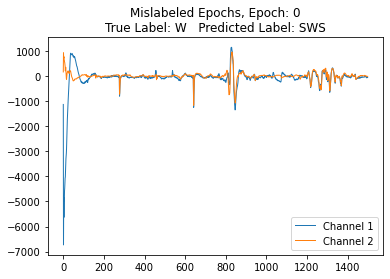

Resetting model.


In [4]:
n_patients = len(P_X)
results = {}

model = iteration['model']

print('Compiling model.')
model.compile(**iteration['compile'])

for leave_out_i in range(n_patients):
    print('*****************************')
    print(f'Leaving out patient {leave_out_i+1}')
    print('*****************************')

    leave_out_dir = Path(iteration_dir, str(f'leave_out_{leave_out_i+1}'))
    if leave_out_dir.exists() and leave_out_dir.is_dir():
        shutil.rmtree(leave_out_dir)
    leave_out_dir.mkdir()

    print('Create data generator.')
    train_gen, test_gen, class_w = create_gens(P_X, P_y, leave_out_i, seq_len=1, fs=125)

    model = iteration['model']
    if iteration['load_model_from_file']:
        print('Loading model from file.')
        model.load(leave_out_dir)
    else:
        assert (issubclass(type(model), AbstractModel))
        print('Fitting model.')
        fit_dir = Path(leave_out_dir,'fit_history')
        if fit_dir.exists() and fit_dir.is_dir():
            shutil.rmtree(fit_dir)
        fit_dir.mkdir()

        fit_history_save_path = os.path.join(leave_out_dir, 'fit_history.png')
        model.fit(train_gen, class_weight=class_w, validation_data=test_gen, **iteration['fit'], title='Fit History, Leave Out Patient ' + str(leave_out_i))

        print('Saving model.')
        model.save(leave_out_dir)

        visualizer.show()

    print('Evaluating model.')

    print('Evaluating Patient Number {}'.format(leave_out_i+1))
    patient_results_dir = os.path.join(leave_out_dir, 'results_patient_'+str(leave_out_i+1))
    if Path(patient_results_dir).exists():
        shutil.rmtree(Path(patient_results_dir))
    Path(patient_results_dir).mkdir()

    run_results = evaluate(model, P_X[leave_out_i], P_y[leave_out_i], save_dir=patient_results_dir)
    results['leave patient ' + str(leave_out_i) + ' out'] = run_results

    visualizer.show()

    print('Resetting model.')
    model.reset()

with open(os.path.join(iteration_dir, 'results.csv'), 'w') as f:
    avg_accuracy = 0.0
    avg_balanced_accuracy = 0.0
    for key in results.keys():
        avg_accuracy = avg_accuracy + results[key]['Accuracy']
        avg_balanced_accuracy = avg_balanced_accuracy + results[key]['Balanced Accuracy']
        f.write("%s, %s\n" % (key, results[key]))

    avg_accuracy = avg_accuracy / n_patients
    avg_balanced_accuracy = avg_balanced_accuracy / n_patients
    f.write("%s, %s\n" % ('Average Accuracy', avg_accuracy))
    f.write("%s, %s\n" % ('Average Balanced Accuracy', avg_balanced_accuracy))
